In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import scipy.linalg as la
from scipy.interpolate import interp1d

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Dropdown, GridspecLayout, Checkbox

from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Polygon
import matplotlib.transforms as transforms
import matplotlib.patches as patches


In [3]:
def coupled_flutter_response(mu,sigma,V, a,b,e,r, mode='Steady - Basic'):
    """
    Compute the eignvalues and eigenvectors for anlaysis of the
    flutter response of a coupled system with the given parameters.

    Parameters:
    mu (float): Mass Ratio.
    sigma (float): Frequency Ratio.
    V (float): Reduced Velocity.
    a (float): Torsional Axis Location.
    b (float): Semi-Chord Length.
    e (float): Eccentricity - Center of Mass Location from torsional axis.
    r (float): Radius of Gyration.
    mode (string): Approximation Chosen for Aerodynamic Influence Matrix; 'Steady', 'Unsteady', 'Quasi-Steady' or 'kussner'. - kussner stc

    Returns:
    Eigen Value Problem Solution: 
    Eigenvalues and Eigenvectors to problem below:

    p**2*I - M*^-1(K* - F) = 0
    """

    # Torsional Axis Offset
    x_theta = (e - a) * b

    # Mass and Stiffness Matrices
    M = np.array([[1, x_theta],
                  [x_theta, r**2]])
    
    K = np.array([
        [sigma**2 / V**2, 2/mu],
        [0, (r**2 / V**2) - ((2 / mu) * (a + 0.5))]])
    
    
    if mode == 'Steady - Basic':

        # Solve the eigenvalue problem
        M_inv = np.linalg.inv(M)
        A = np.dot(M_inv, K)
        eigvals, eigvecs = np.linalg.eig(A)

        return eigvals, eigvecs
    elif mode == 'Steady - Basic2':
        K = np.array([[sigma**2 / V**2, 2 /mu],
                    [0, r**2 / V**2]])
        F = np.array([[0, -2 * np.pi],
                      [0, -2 * np.pi * (a + 0.5)]])
        
        # Solve the eigenvalue problemb by constructing a system matrix instead of directly solving
        A = np.block([
        [np.zeros_like(M), np.eye(2)],
        [-la.inv(M) @ (K - F), np.zeros_like(M)]
        ])

        # Compute eigenvalues
        eigvals, eigvecs = la.eig(A)
    
        return eigvals, eigvecs
    else:
        raise ValueError("Invalid mode selected; choose 'Steady - Basic' or 'Steady - Basic2'.")
    
    # Function to find closest points
def find_closest_points(reference, target, max_points):
    reference = np.array(reference)
    target = np.array(target)
    differences = np.abs(reference[:, None] - target[None, :])
    closest_indices = np.argmin(differences, axis=0)
    closest_points = np.unique(reference[closest_indices])
    if len(closest_points) > max_points:
        distances = np.abs(closest_points[:, None] - target).min(axis=1)
        sorted_indices = np.argsort(distances)
        closest_points = closest_points[sorted_indices][:max_points]
    return closest_points, closest_indices


Reduced velocity (V): 2.5820


C:\Users\ayode\AppData\Local\Temp\ipykernel_23756\976095535.py:29: RuntimeWarning: invalid value encountered in scalar divide
  V_squared = (2 * A) / (-B + np.sqrt(discriminant))
C:\Users\ayode\AppData\Local\Temp\ipykernel_23756\976095535.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

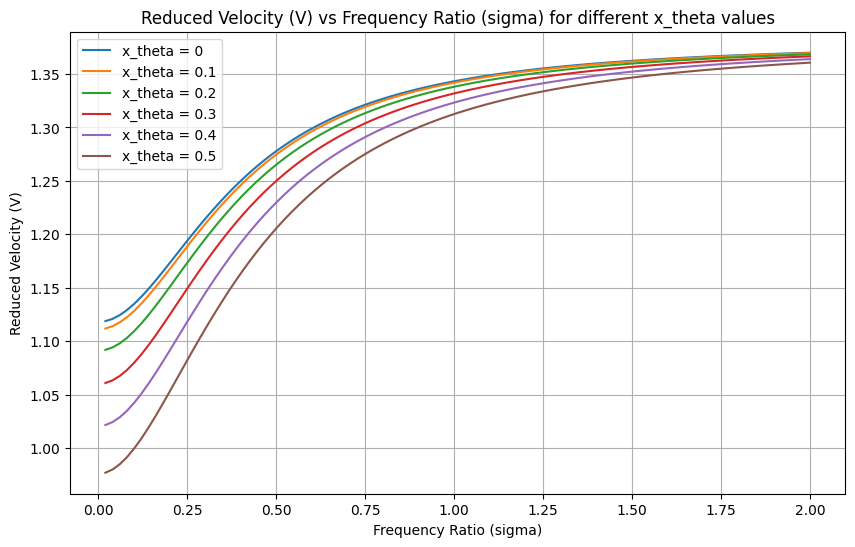

In [4]:
def model_validation(sigma, p, r, mu, a, x_theta):
    """
    Calculate the reduced velocity (V) in terms of frequency ratio (sigma) and other parameters.

    Parameters:
    sigma (float): Frequency ratio
    p (float): Eigenvalue parameter (typically related to flutter frequency and damping)
    r (float): Radius of gyration
    mu (float): Mass ratio
    a (float): Torsional axis offset
    x_theta (float): Coupling term

    Returns:
    float: Reduced velocity (V)
    """
    # Define the coefficient C based on the parameters provided
    C = (-2 * sigma**2 / mu * (a + 0.5) - 2 * p**2 / mu * (a + 0.5) - p**4 * x_theta**2)

    # Calculate the discriminant for the quadratic equation
    B = r**2 * (sigma**2 + p**2)
    A = r**2 * sigma**2
    discriminant = B**2 - 4 * A * C

    # Check if the discriminant is non-negative
    if discriminant < 0:
        raise ValueError("The discriminant is negative, resulting in complex reduced velocity. Please check your input parameters.")

    # Calculate V^2 from the quadratic solution (taking the positive branch for physical meaningfulness)
    V_squared = (2 * A) / (-B + np.sqrt(discriminant))

    # Take the square root to get V
    V = np.sqrt(V_squared)

    return V

# Example usage
sigma = 1.0  # Frequency ratio
p = 0.5 #+ 0.25j      # Eigenvalue parameter
r = 0.25     # Radius of gyration
mu = 20    # Mass ratio
a = -0.4     # Torsional axis offset
x_theta = 0.1  # Coupling term

# Calculate reduced velocity
try:
    V = model_validation(sigma, p, r, mu, a, x_theta)
    print(f"Reduced velocity (V): {V:.4f}")
except ValueError as e:
    print(f"Error: {e}")

# Vary sigma from 0 to 2, given mu = 2, a = -0.3, and r = 0.5
sigma_values = np.linspace(0, 2, 100)
mu = 2
a = -0.3
r = 0.5
x_theta_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(10, 6))

# Initalize dataframe to store first value of V for each x_theta
data = pd.DataFrame({'x_theta': x_theta_values, 'V': [1]*len(x_theta_values)})

for x_theta in x_theta_values:
    V_values = [model_validation(sigma, p, r, mu, a, x_theta) for sigma in sigma_values]
    data['V'][x_theta_values.index(x_theta)] = V_values[1]
    plt.plot(sigma_values, V_values, label=f'x_theta = {x_theta}')

plt.xlabel('Frequency Ratio (sigma)')
plt.ylabel('Reduced Velocity (V)')
plt.title('Reduced Velocity (V) vs Frequency Ratio (sigma) for different x_theta values')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# # Given parameters - VKI
# m = 5 * np.pi  # kg/m
# rho = 1
# w_theta = 100  # Hz, vki
# w_theta = 100 #
# u = 100  # m/s

# a = -0.2 # vki
# b = 0.5
# e = -0.1

# r = 0.5 # vki

# sigma = 0.4

# # Derived parameters
# w_h = w_theta * sigma
# V = u/(b*w_theta)  # Reduced velocity
# mu = m / (rho * np.pi * b**2) # 20 for m = 5*pi

# vals, _ = coupled_flutter_response(mu,sigma,V,a,b,e,r, mode='Steady - Basic2')
# print(vals)
##
# Given parameters - Intro to SDA
m = 5 * np.pi  # kg/m
rho = 1
w_theta = 100  # Hz, vki
mu = 20
w_theta = 1 # intro to sda
u = 100  # m/s

a = -0.2 # vki
b = 1
e = -0.1

# r = 0.5 # vki
r = np.sqrt(6/25) # intro to sda
   
sigma = 0.4

# Derived parameters
w_h = w_theta * sigma
# V = u/(b*w_theta) # vki # Reduced velocity
V = 0.5


# mu = m / (rho * np.pi * b**2) # 20 for m = 5*pi
n_V = 100
n_mu = 20
V_range = np.linspace(0.5,2.5, n_V)
mu_range = np.linspace(1,100,n_mu)

C:\Users\ayode\AppData\Local\Temp\ipykernel_23756\3597378476.py:22: RuntimeWarning: divide by zero encountered in divide
  zeta = eigenvalues.real/omega


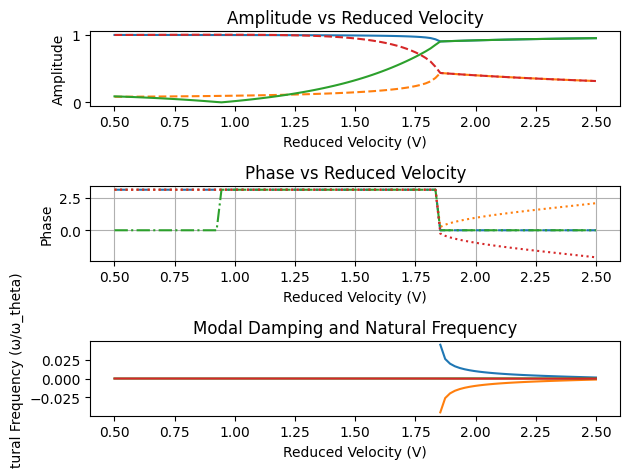

In [7]:
# Storage for results
omega_list = []
zeta_list = []
amp_phase_list = []

# Loop through reduced velocities to calculate eigenvalues and eigenvectors
for V in V_range:
    eigenvalues, eigenvectors = coupled_flutter_response(mu, sigma, V, a, b, e, r, mode= 'Steady - Basic')
    # print(f"Eigenvalues: {eigenvalues}")
    # print(f"Eigenvectors: {eigenvectors}")
    # break

    # Solve for w_theta at this V
    w_theta = u/b*V
    # print(f"V: {V}, w_theta: {w_theta}")
    # Extract natural frequencies and damping ratios
    #omega = np.abs(eigenvalues.imag)
    #zeta = -eigenvalues.real / omega
    #zeta = eigenvalues.real/omega

    omega = eigenvalues.imag
    zeta = eigenvalues.real/omega
    omega_list.append(omega / w_theta)
    zeta_list.append(zeta/ w_theta)

    # Amplitude and phase for each mode
    amplitudes = np.abs(eigenvectors).real
    phases = np.angle(eigenvectors)
    amp_phase_list.append((amplitudes, phases))

# amplitudes = [amp_phase[0][:, i] for amp_phase in amp_phase_list]
# phases = [amp_phase[1][:, i]/np.pi for amp_phase in amp_phase_list]
# for i in range(0,2):
#     print(f"Concat: {i} {amp_phase_list[i]}")
#     print(f"Amps: {i} {amplitudes[i]}")
#     print(f"Phases {i} {phases[i]}")

plt.figsize=(20, 12)
plt.subplot(3, 1, 1)
for i, label in enumerate(["Plunge", "Twist"]):
    amplitudes = [amp_phase[0][:, i] for amp_phase in amp_phase_list]
    plt.plot(V_range, [amp[0] for amp in amplitudes], label=f"Mode 1 {label} Amplitude")
    plt.plot(V_range, [amp[1] for amp in amplitudes], label=f"Mode 2 {label} Amplitude", linestyle='--')
plt.xlabel("Reduced Velocity (V)")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Reduced Velocity")

# plt.subplots_adjust(hspace=0.5)

# Subplot for Phase - Normaalize to degrees??
plt.subplot(3, 1, 2)
for i, label in enumerate(["Plunge", "Twist"]):
    phases = [amp_phase[1][:, i] for amp_phase in amp_phase_list]
    plt.plot(V_range, [phase[0] for phase in phases], label=f"Mode 1 {label} Phase", linestyle='-.')
    plt.plot(V_range, [phase[1] for phase in phases], label=f"Mode 2 {label} Phase", linestyle=':')
plt.xlabel("Reduced Velocity (V)")
plt.ylabel("Phase")
plt.title("Phase vs Reduced Velocity")
#plt.legend(fontsize='small')
plt.grid()

# # Reverse zeta list
# zeta_list = zeta_list[::-1]
# omega_list = omega_list[::-1]
# Plolt zeta values - supposed modal damping 
plt.subplot(3,1,3)
plt.plot(V_range, zeta_list)
plt.plot(V_range, omega_list)
plt.title('Modal Damping and Natural Frequency')
plt.xlabel('Reduced Velocity (V)')
plt.ylabel('Natural Frequency (ω/ω_theta)')


#plt.legend(fontsize='small')
plt.tight_layout()


In [23]:
# Data imports and manipulation

# Directory structure
# -- Models
# ---- Coupled Bening-Torsion Flutter
# ------ Coupled Bending-Torsion Flutter.ipynb
# ------ Validation.ipynb
# -- Datasets
# ---- sda_5_3.csv
# ---- sda_5_4.csv
# ---- sda_5_14.csv




# File paths
fp_5_3 = '../../Datasets/sda_5_3.csv'
fp_5_4 = '../../Datasets/sda_5_4.csv'
fp_5_14 = '../../Datasets/sda_5_14.csv'

sda_5_3_data = pd.read_csv(fp_5_3)
sda_5_4_data = pd.read_csv(fp_5_4)
sda_5_14_data = pd.read_csv(fp_5_14)


# Split data by column
red_velocity2 = sda_5_4_data['x']
modal_damping_ratio = sda_5_4_data[' y']


red_velocity1 = sda_5_3_data['x']
modal_freq_ratio = sda_5_3_data[' y']

mass_ratios = sda_5_14_data['x']
red_velocity3 = sda_5_14_data[' y']


filtered_red_velocity1, indices1 = find_closest_points(red_velocity1, V_range, n_V)
filtered_red_velocity2, indices2 = find_closest_points(red_velocity2, V_range, n_V)
filtered_mass_ratios, indices3 = find_closest_points(mass_ratios, mu_range, n_mu)


modal_freq_ratio_interp = modal_freq_ratio[indices1]
modal_damping_ratio_interp = modal_damping_ratio[indices2]
red_velocity3_interp = red_velocity3[indices3]


Pearson Correlation Coefficient (Interp): 0.3792210813292314
Normalized Root Mean Square Error (Interp): 0.44253867944296776
Mean Absolute Error (Interp): 0.21264732145513013


Text(0.5, 1.0, 'Reduced Velocity vs Mass Ratio')

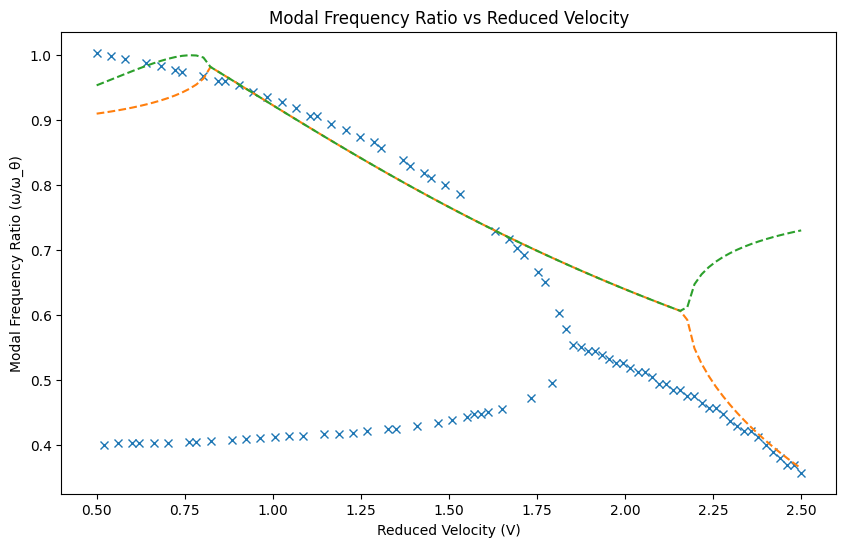

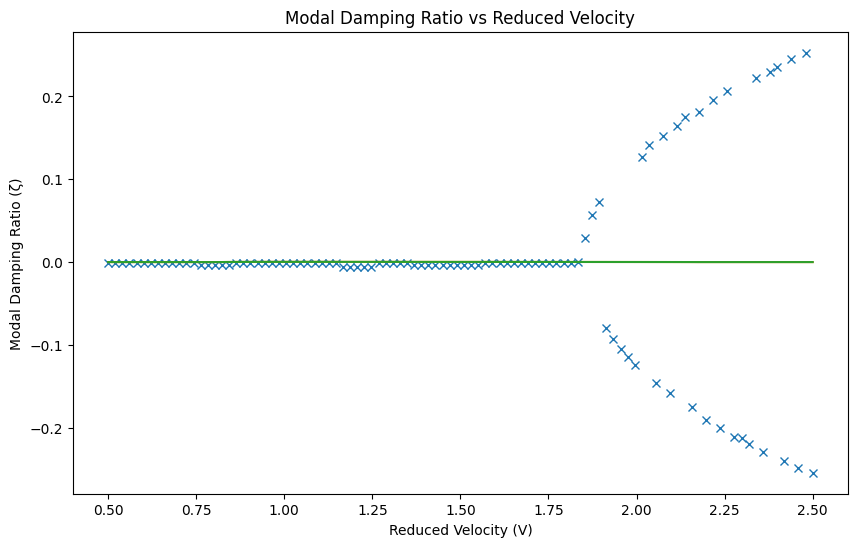

<Figure size 1000x600 with 0 Axes>

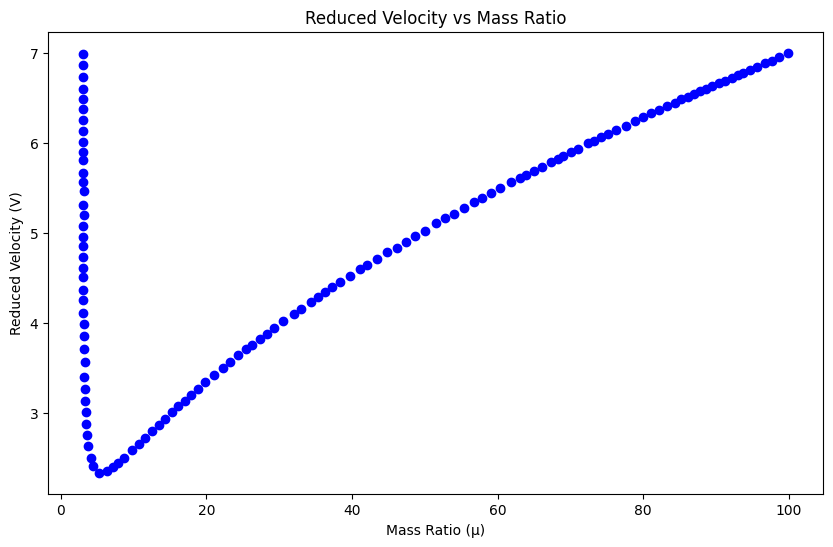

In [24]:
# Plotting and Validation

plt.figure(figsize=(10, 6))
#plt.plot(red_velocity1, modal_freq_ratio, 'o', label='Original Data (Modal Frequency)')# Original Data - Non Interpolated
#plt.plot(V_range,omega_list) # [omega * w_theta for omega in omega_list], label='Natural Frequency', linestyle='-.')# Modal Frequency Ratios
#plt.plot(V_range, zeta_list, label='Modal Damping Ratio', linestyle='--')# Modal Damping Ratios

# plot of modal frequency ratio against reduced velocity - interpolated
plt.plot(V_range, modal_freq_ratio_interp, 'x', linestyle = 'None', label='Interpolated Data (Modal Frequency)')

# Plot of modal frequency ratio against reduced velocity - computed
freq_ratio_original = []
for i, label in enumerate(["Plunge", "Twist"]):
    amplitudes = [amp_phase[0][:, i] for amp_phase in amp_phase_list]
    #plt.plot(V_range, [amp[0] for amp in amplitudes], label=f"Mode 1 {label} Amplitude")
    plt.plot(V_range,[amp[1] for amp in amplitudes] , label=f"Mode 2 {label} Amplitude", linestyle='--')
    freq_ratio_original.append([amp[1] for amp in amplitudes])
plt.title('Modal Frequency Ratio vs Reduced Velocity')
plt.xlabel('Reduced Velocity (V)')
plt.ylabel('Modal Frequency Ratio (ω/ω_θ)')




# Plot of modal damping ratio against reduced velocity - interpolated
plt.figure(figsize=(10, 6))
#plt.plot(red_velocity2, modal_damping_ratio, 'o', label='Original Data (Modal Damping Ratio)')


#plt.plot(V_range, omega_list, label='Natural Frequency', linestyle='-.')# Modal Frequency Ratios
#plt.plot(V_range, modal_damping_ratio_interp, 'x', linestyle = 'None', color = 'b', label='Interpolated Data (Modal Damping)')
#plt.plot(red_velocity2, modal_damping_ratio, marker='o',linestyle = 'None', color='b')

# Plot of modal damping ratio against reduced velocity - interpolated
plt.plot(V_range, modal_damping_ratio_interp, 'x', linestyle = 'None', label='Interpolated Data (Modal Damping Ratio)')
plt.plot(V_range,omega_list) # [omega * w_theta for omega in omega_list], label='Natural Frequency', linestyle='-.')# Modal Frequency Ratios
# Plot of modal damping ratio against reduced velocity - computed
#plt.plot(V_range, zeta_list)


plt.title('Modal Damping Ratio vs Reduced Velocity')
plt.xlabel('Reduced Velocity (V)')
plt.ylabel('Modal Damping Ratio (ζ)')

#[amp[1] for amp in amplitudes]

# plt.figure(figsize=(10, 6))
# plt.plot(V_range, modal_freq_ratio_interp, 'x', linestyle = 'None', color = 'b', label='Interpolated Data (Modal Frequency)')
# #plt.plot(red_velocity1, modal_freq_ratio_interp, marker='o',linestyle = 'None', color='b')# Amplitudes


plt.figure(figsize=(10, 6))


##

freq_ratio_original = [amp[1] for amp in amplitudes]

# Calculate error metrics: pearson correlation coefficient, normalized root mean square error, mean absolute error; MAE less meaningful as it is not normalized, hence dependent on discretization
pearson_corr = np.corrcoef(modal_freq_ratio_interp, freq_ratio_original)[0, 1]
print(f"Pearson Correlation Coefficient (Interp): {pearson_corr}")

nrmse = np.sqrt(np.mean((modal_freq_ratio_interp - freq_ratio_original)**2)) / (np.max(modal_freq_ratio_interp) - np.min(modal_freq_ratio_interp))
print(f"Normalized Root Mean Square Error (Interp): {nrmse}")

mae = np.mean(np.abs(modal_freq_ratio_interp - freq_ratio_original))
print(f"Mean Absolute Error (Interp): {mae}")


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(mass_ratios, red_velocity3, marker='o', linestyle='None', color='b')
plt.xlabel('Mass Ratio (μ)')
plt.ylabel('Reduced Velocity (V)')
plt.title('Reduced Velocity vs Mass Ratio')

C:\Users\ayode\AppData\Local\Temp\ipykernel_23756\2721035977.py:16: RuntimeWarning: divide by zero encountered in divide
  zeta = -eigenvalues.real / omega
C:\Users\ayode\AppData\Local\Temp\ipykernel_23756\2721035977.py:69: RuntimeWarning: divide by zero encountered in divide
  zeta = -eigenvalues.real / omega


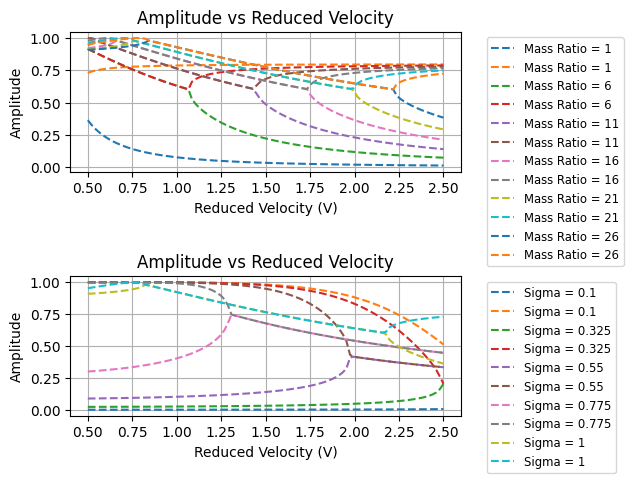

In [18]:
mass_ratios = [1, 6, 11, 16, 21, 26]
V_range = np.linspace(0.5, 2.5, n_V)

# Storage for results
list_of_lists = []

for mu in mass_ratios:
    omega_list = []
    zeta_list = []
    amp_phase_list = []
    # Loop through reduced velocities to calculate eigenvalues and eigenvectors
    for V in V_range:
        eigenvalues, eigenvectors = coupled_flutter_response(mu, sigma, V, a, b, e, r)
        # Extract natural frequencies and damping ratios
        omega = np.abs(eigenvalues.imag)
        zeta = -eigenvalues.real / omega
        omega_list.append(omega / w_theta)
        zeta_list.append(zeta)

        # Amplitude and phase for each mode
        amplitudes = np.abs(eigenvectors).real
        phases = np.angle(eigenvectors)
        amp_phase_list.append((amplitudes, phases))
    
    list_of_lists.append(amp_phase_list)

# plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
for mu, amp_phase_list in zip(mass_ratios, list_of_lists):
    for i, label in enumerate(["Plunge", "Twist"]):
        amplitudes = [amp_phase[0][:, i] for amp_phase in amp_phase_list]
        #plt.plot(V_range, [amp[0] for amp in amplitudes], label=f"Mass Ratio {mu} Mode 1 {label} Amplitude")
        #plt.plot(V_range, [amp[1] for amp in amplitudes], label=f"Mass Ratio {mu} Mode 2 {label} Amplitude", linestyle='--')
        plt.plot(V_range, [amp[1] for amp in amplitudes], label=f"Mass Ratio = {mu}", linestyle='--')


plt.xlabel("Reduced Velocity (V)")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Reduced Velocity")
plt.legend(fontsize='small',bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
# plt.show()

# Varyh sigma across [0.1,0,325,0.55, 0.775, 1] for mu = 25
sigma_values = [0.1, 0.325, 0.55, 0.775, 1]
mu = 25
a = -0.2
b = 0.5
e = -0.1
r = 0.5

#n = 100 # Number of points


V_range = np.linspace(0.5, 2.5, n_V)

# Storage for results
list_of_lists = []

for sigma in sigma_values:
    omega_list = []
    zeta_list = []
    amp_phase_list = []
    # Loop through reduced velocities to calculate eigenvalues and eigenvectors
    for V in V_range:
        eigenvalues, eigenvectors = coupled_flutter_response(mu, sigma, V, a, b, e, r)
        # Extract natural frequencies and damping ratios
        omega = np.abs(eigenvalues.imag)
        zeta = -eigenvalues.real / omega
        omega_list.append(omega / w_theta)
        zeta_list.append(zeta)

        # Amplitude and phase for each mode
        amplitudes = np.abs(eigenvectors).real
        phases = np.angle(eigenvectors)
        amp_phase_list.append((amplitudes, phases))
    
    list_of_lists.append(amp_phase_list)

plt.subplot(2,1,2)
for sigma, amp_phase_list in zip(sigma_values, list_of_lists):
    for i, label in enumerate(["Plunge", "Twist"]):
        amplitudes = [amp_phase[0][:, i] for amp_phase in amp_phase_list]
        #plt.plot(V_range, [amp[1] for amp in amplitudes], label=f"Sigma {sigma} Mode 2 {label} Amplitude", linestyle='--')
        plt.plot(V_range, [amp[1] for amp in amplitudes], label=f"Sigma = {sigma}", linestyle='--')

plt.xlabel("Reduced Velocity (V)")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Reduced Velocity")
plt.legend(fontsize='small',bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()
